In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy import stats
from datetime import datetime

# Seaborn style settings
sns.set_theme(style="ticks", palette="mako")

In [2]:
master_df = pd.read_csv("data/2016_2021_master_df.csv")
master_df["DATE_PST"] = pd.to_datetime(master_df["DATE_PST"])
master_df.set_index("DATE_PST", inplace=True)
display(master_df.head())
print(master_df.shape)

,Vancouver_Clark_Drive_PM25,Vancouver_International_Airport_#2_PM25,North_Vancouver_Mahon_Park_PM25,North_Vancouver_Second_Narrows_PM25
DATE_PST,,,,
2016-01-01 01:00:00,30.557,22.71692,22.798870,NaN
2016-01-01 02:00:00,34.661,21.95020,22.909090,6.341111
2016-01-01 03:00:00,35.419,21.25953,19.857730,5.340278
2016-01-01 04:00:00,24.335,19.93333,13.575990,3.907917
2016-01-01 05:00:00,29.336,19.07922,7.079589,7.235889


(57014, 4)


In [3]:
# Melting
master_df = pd.melt(master_df,
                    value_vars=[
                    "Vancouver_Clark_Drive_PM25",\
                    "Vancouver_International_Airport_#2_PM25",\
                    "North_Vancouver_Mahon_Park_PM25",\
                    "North_Vancouver_Second_Narrows_PM25"
                    ],
                    ignore_index=False).rename(columns={
                    "variable": "Station",
                    "value": "PM 2.5"})
display(master_df.head())
print(master_df.shape)

,Station,PM 2.5
DATE_PST,,
2016-01-01 01:00:00,Vancouver_Clark_Drive_PM25,30.557
2016-01-01 02:00:00,Vancouver_Clark_Drive_PM25,34.661
2016-01-01 03:00:00,Vancouver_Clark_Drive_PM25,35.419
2016-01-01 04:00:00,Vancouver_Clark_Drive_PM25,24.335
2016-01-01 05:00:00,Vancouver_Clark_Drive_PM25,29.336


(228056, 2)


## Visualizing Missingness

In [4]:
# Dummy variable to keep track of missing samples and missing sample length
master_df["isMissing"] = np.where(master_df["PM 2.5"].isnull(), 1, 0)
master_df.head()

,Station,PM 2.5,isMissing
DATE_PST,,,
2016-01-01 01:00:00,Vancouver_Clark_Drive_PM25,30.557,0
2016-01-01 02:00:00,Vancouver_Clark_Drive_PM25,34.661,0
2016-01-01 03:00:00,Vancouver_Clark_Drive_PM25,35.419,0
2016-01-01 04:00:00,Vancouver_Clark_Drive_PM25,24.335,0
2016-01-01 05:00:00,Vancouver_Clark_Drive_PM25,29.336,0


In [5]:
master_df['isMissing'].sum()

4958

In [6]:
# List of stations
stations = master_df["Station"].unique().tolist()
stations

['Vancouver_Clark_Drive_PM25',
 'Vancouver_International_Airport_#2_PM25',
 'North_Vancouver_Mahon_Park_PM25',
 'North_Vancouver_Second_Narrows_PM25']

In [7]:
# Isolating stations on independent dataframes
datasets = {}
for station in stations:
    datasets[station] = master_df[master_df["Station"] == station]
    datasets[station] = datasets[station][["PM 2.5", "isMissing"]]
    datasets[station].reset_index(inplace=True)

del master_df
datasets.keys()

dict_keys(['Vancouver_Clark_Drive_PM25', 'Vancouver_International_Airport_#2_PM25', 'North_Vancouver_Mahon_Park_PM25', 'North_Vancouver_Second_Narrows_PM25'])

In [8]:
# Identifying isolated missing values and continuous missing values

# Dictionary to track missing value sequence lengths per station
seq_max_dict = {}

# Auxiliar column to identify missing value interval lengths
for station in stations:
    # Initialize list of sequence lengths per station
    seq_max_dict[station] = []

    # Initialize missing value sequency array and maximum sequence length
    nan_seq_length = np.zeros(len(datasets[station]))
    seq_max = 0

    # Iterate on each dataset to count missing value sequence lengths
    for i in range(0, len(datasets[station])):
        seq = 0  # Sequence counter
        while datasets[station].loc[i, "isMissing"]:
            i += 1  # Add up to iterator while still missing
            seq += 1  # Add up to sequence length while still missing
        if seq:  # If in a missing sequence
            if seq_max < seq:  # If max sequence length < current sequence
                seq_max = seq  # Update maximum sequence length
                seq_max_dict[station].append(seq_max) # Append to tracking dictionary
        else:
            seq_max = 0  # If not in a missing sequence reset max sequence lenght
        # Update sequence length array with maximum sequence length
        nan_seq_length[(i - seq)] = seq_max
    
    datasets[station]["seqMissing"] = nan_seq_length.astype(int)

    # Assert tracking dictionary sum of sequence lengths matches total missing values
    assert datasets[station]['isMissing'].sum() == sum(seq_max_dict[station])

In [9]:
datasets['North_Vancouver_Second_Narrows_PM25'].loc[datasets['North_Vancouver_Second_Narrows_PM25']['isMissing'] > 0].head(10)

,DATE_PST,PM 2.5,isMissing,seqMissing
0,2016-01-01 01:00:00,NaN,1,1
1757,2016-03-14 06:00:00,NaN,1,3
1758,2016-03-14 07:00:00,NaN,1,3
1759,2016-03-14 08:00:00,NaN,1,3
1764,2016-03-14 13:00:00,NaN,1,1
2125,2016-03-29 14:00:00,NaN,1,1
2507,2016-04-14 12:00:00,NaN,1,2
2508,2016-04-14 13:00:00,NaN,1,2
3493,2016-05-25 14:00:00,NaN,1,1
5120,2016-08-01 09:00:00,NaN,1,26


In [10]:
# Recomposing Master DataFrame
master_df = pd.concat(datasets).reset_index(level=0)

# Renaming station column
master_df["STATION"] = master_df["level_0"]
master_df = master_df[["DATE_PST", "STATION", "PM 2.5", "isMissing", "seqMissing"]]
# master_df.drop("level_0", axis=1, inplace=True)

# Redefining DATE_PST index
master_df.set_index("DATE_PST", inplace=True)
master_df.head()

,STATION,PM 2.5,isMissing,seqMissing
DATE_PST,,,,
2016-01-01 01:00:00,Vancouver_Clark_Drive_PM25,30.557,0,0
2016-01-01 02:00:00,Vancouver_Clark_Drive_PM25,34.661,0,0
2016-01-01 03:00:00,Vancouver_Clark_Drive_PM25,35.419,0,0
2016-01-01 04:00:00,Vancouver_Clark_Drive_PM25,24.335,0,0
2016-01-01 05:00:00,Vancouver_Clark_Drive_PM25,29.336,0,0


### Thresholding missing sequence length
* Isolated Missing Value (IMV)
* Continuous Missing Value (CMV)

In [11]:
# Isolated Missing Value threshold
# seqMissing > IMV_THRESHOLD: Continuous missing value (1)
# seqMissing <= IMV_THRESHOLD: Isolated missing value (0)
IMV_THRESHOLD = 2

master_df["isCMV"] = np.where(master_df["seqMissing"] > IMV_THRESHOLD, 1, 0)
master_df.head()

,STATION,PM 2.5,isMissing,seqMissing,isCMV
DATE_PST,,,,,
2016-01-01 01:00:00,Vancouver_Clark_Drive_PM25,30.557,0,0,0
2016-01-01 02:00:00,Vancouver_Clark_Drive_PM25,34.661,0,0,0
2016-01-01 03:00:00,Vancouver_Clark_Drive_PM25,35.419,0,0,0
2016-01-01 04:00:00,Vancouver_Clark_Drive_PM25,24.335,0,0,0
2016-01-01 05:00:00,Vancouver_Clark_Drive_PM25,29.336,0,0,0


In [12]:
master_df.loc[
    (master_df['STATION'] == 'North_Vancouver_Second_Narrows_PM25') &
    (master_df['isMissing'])
    ].head(10)

,STATION,PM 2.5,isMissing,seqMissing,isCMV
DATE_PST,,,,,
2016-01-01 01:00:00,North_Vancouver_Second_Narrows_PM25,NaN,1,1,0
2016-03-14 06:00:00,North_Vancouver_Second_Narrows_PM25,NaN,1,3,1
2016-03-14 07:00:00,North_Vancouver_Second_Narrows_PM25,NaN,1,3,1
2016-03-14 08:00:00,North_Vancouver_Second_Narrows_PM25,NaN,1,3,1
2016-03-14 13:00:00,North_Vancouver_Second_Narrows_PM25,NaN,1,1,0
2016-03-29 14:00:00,North_Vancouver_Second_Narrows_PM25,NaN,1,1,0
2016-04-14 12:00:00,North_Vancouver_Second_Narrows_PM25,NaN,1,2,0
2016-04-14 13:00:00,North_Vancouver_Second_Narrows_PM25,NaN,1,2,0
2016-05-25 14:00:00,North_Vancouver_Second_Narrows_PM25,NaN,1,1,0


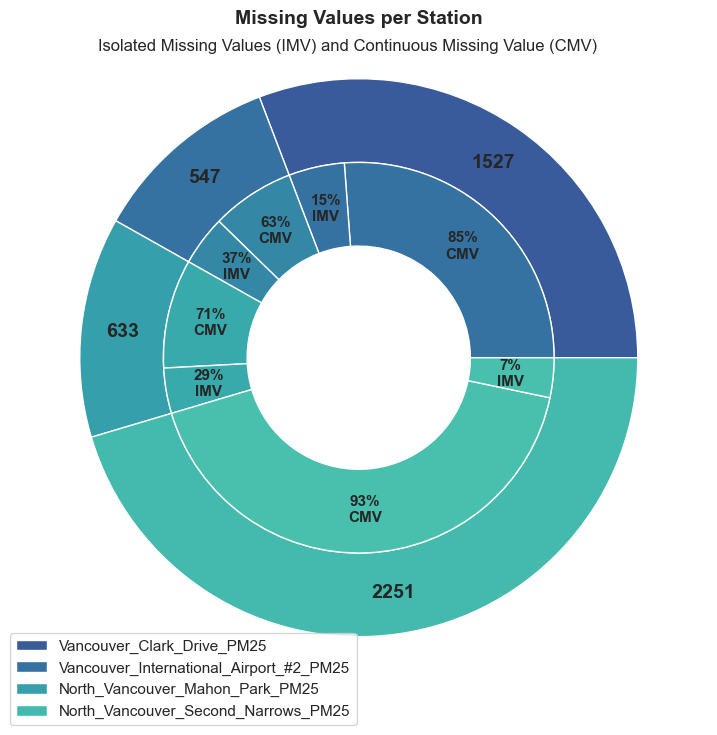

In [13]:
# Continuous missing samples // Isolated missing values count
stations = []
tot_missing = []
stations_cmv_imv = []
stations_cmv_imv_label = []

# Count of CMV and IMV intervals and percentage out of total missing
for station in pd.unique(master_df["STATION"]):
    stations.append(station)
    tot_missing_current = sum(master_df["isMissing"][master_df["STATION"] == station])
    tot_missing.append(tot_missing_current)
    tot_cmv = sum(master_df["isCMV"][master_df["STATION"] == station])
    stations_cmv_imv.append(tot_cmv)
    stations_cmv_imv_label.append(f"{tot_cmv/tot_missing_current * 100:.0f}%\nCMV")
    tot_imv = tot_missing_current - tot_cmv
    stations_cmv_imv.append(tot_imv)
    stations_cmv_imv_label.append(f"{tot_imv/tot_missing_current * 100:.0f}%\nIMV")

# Stacked pie charts with IMV and CMS percentages
fig, ax = plt.subplots(figsize=(9, 9))
ax.axis("equal")
width = 0.3

# Color map
cm = plt.get_cmap("mako")
cout = cm([100, 120, 160, 185])

# Outer pie chart (total missing values per station)
pie, texts1 = ax.pie(
    tot_missing,
    radius=1,
    labels=tot_missing,
    colors=cout,
    labeldistance=0.85,
    textprops={"fontsize": 14, "weight": "bold"},
)
for t in texts1:
    t.set_horizontalalignment("center")
plt.legend(pie, stations, loc=(0, -0.03))
plt.setp(pie, width=width, edgecolor="white")

# Inner pie chart (percentage of IMV and CMV out of total missing)
cin = cm([120, 120, 140, 140, 170, 170, 190, 190])
pie2, texts2 = ax.pie(
    stations_cmv_imv,
    radius=1 - width,
    labels=stations_cmv_imv_label,
    labeldistance=0.78,
    colors=cin,
    textprops={"weight": "bold"},
)
for t in texts2:
    t.set_horizontalalignment("center")
plt.setp(pie2, width=width, edgecolor="white")
plt.title("Missing Values per Station", fontsize=14, weight="bold", y=0.97)
plt.suptitle(
    "Isolated Missing Values (IMV) and Continuous Missing Value (CMV)",
    fontsize=12,
    y=0.85,
)
plt.show()

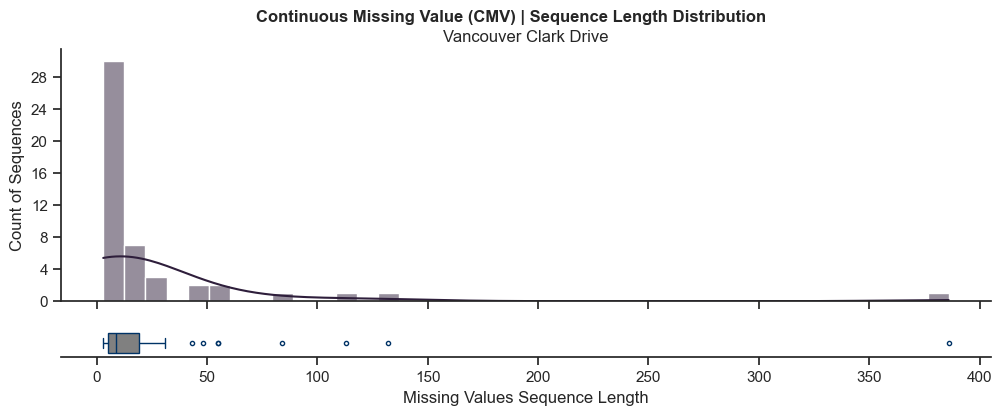

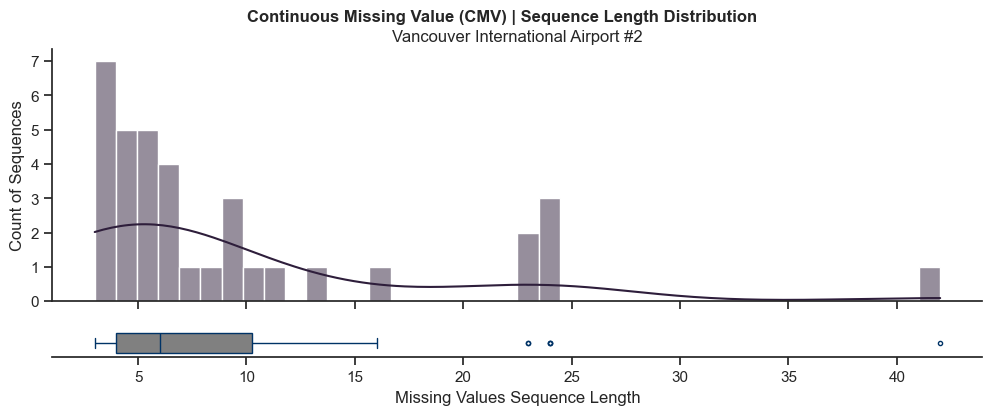

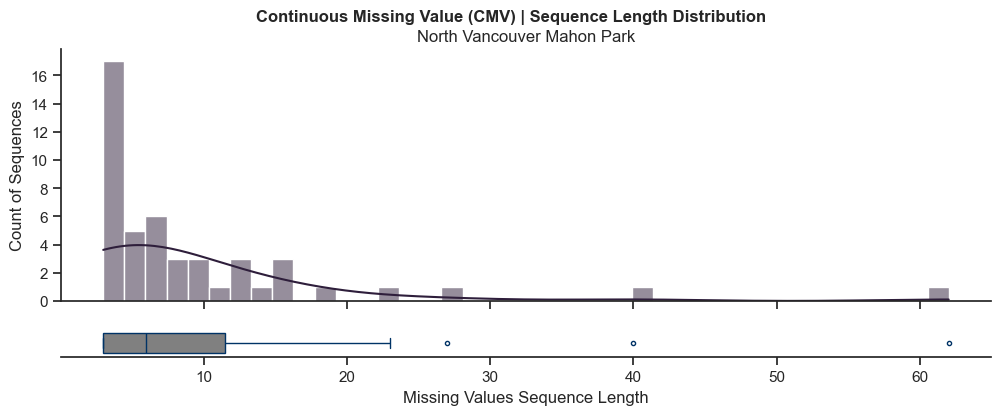

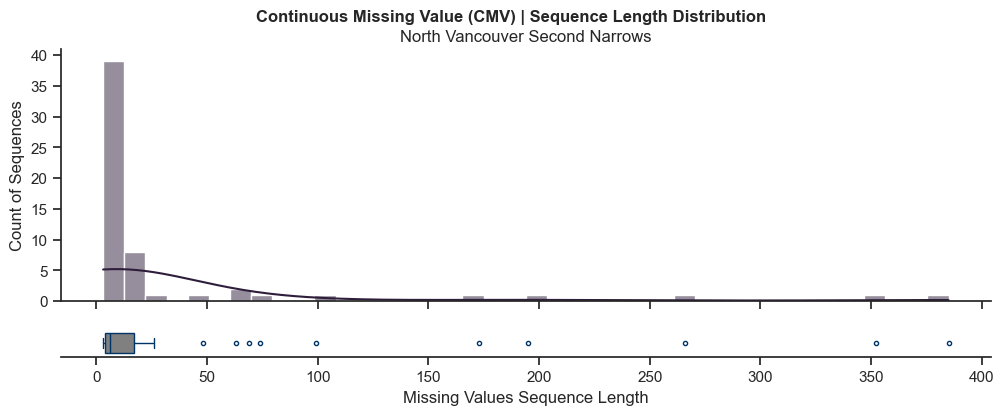

In [14]:
# Distribution of CMV Sequence Length
for station in stations:
    _, (ax_hist, ax_box) = plt.subplots(
        2,
        sharex=True,
        gridspec_kw={"height_ratios": (.9, .10)},
        figsize=(12,4)
    )

    plot_title = station[:-5].replace('_', ' ')

    sns.histplot(
        x=[i for i in seq_max_dict[station] if i > IMV_THRESHOLD],
        kde=True, bins=40, ax=ax_hist
    )
    sns.boxplot(
        x=[i for i in seq_max_dict[station] if i > IMV_THRESHOLD],
        ax=ax_box, width=0.7, color='0.5', linecolor='#003366', flierprops={'marker': '.'}
    )

    ax_hist.set(title=plot_title, ylabel=f'Count of Sequences')
    ax_hist.yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.suptitle('Continuous Missing Value (CMV) | Sequence Length Distribution',
                 fontweight='bold',
                 fontsize=12)
    ax_box.set(yticks=[], xlabel='Missing Values Sequence Length')
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)

### Generating Artificial Missing Data
Artificially missing data will be generated to evaluate imputation methods.

In [15]:
%load_ext autoreload
%autoreload 2
from tshelpers.subset import subset_interval, create_missing
from tshelpers.plot import plot_sequence, plot_compare, plot_missing
from tshelpers.metrics import rmse_score, mae_score

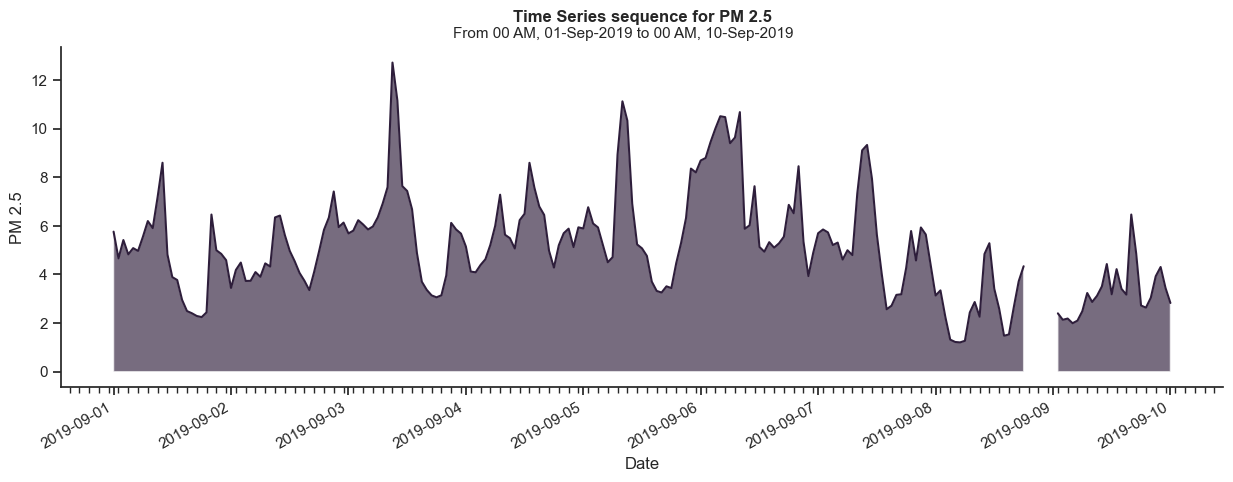

In [16]:
station_subset = master_df[master_df["STATION"] == "North_Vancouver_Mahon_Park_PM25"]

subset, subset_missing = create_missing(
    data=station_subset,
    value="PM 2.5",
    start=datetime(2019, 9, 1),
    end=datetime(2019, 9, 10),
    missing_length=6,
    padding=24,
    missing_index="end",
)

plot_sequence(data=subset_missing, value="PM 2.5")

In [17]:
subset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 217 entries, 2019-09-01 00:00:00 to 2019-09-10 00:00:00
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   STATION     217 non-null    object 
 1   PM 2.5      217 non-null    float64
 2   isMissing   217 non-null    int64  
 3   seqMissing  217 non-null    int64  
 4   isCMV       217 non-null    int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 10.2+ KB


In [18]:
subset_missing.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 217 entries, 2019-09-01 00:00:00 to 2019-09-10 00:00:00
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   STATION     217 non-null    object 
 1   PM 2.5      211 non-null    float64
 2   isMissing   217 non-null    int64  
 3   seqMissing  217 non-null    int64  
 4   isCMV       217 non-null    int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 10.2+ KB


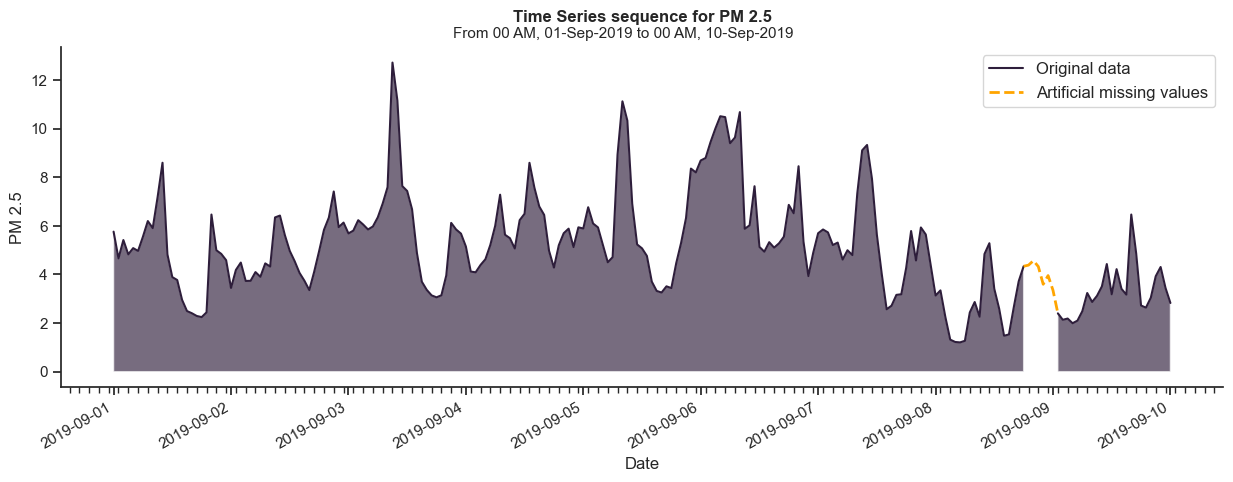

In [19]:
plot_compare(
    data=subset,                            # Subset to plot
    data_missing=subset_missing,            # Subset with missing values to plot
    value="PM 2.5",                         # Variable to plot from subset
    value_missing="PM 2.5",                 # Variable to plot from subset_missing
    missing_only=True,                      # Plt only the section with missing values from subset_missing
    start=datetime(2019, 9, 1),
    end=datetime(2019, 9, 10),
    fill=True,
    data_label="Artificial missing values", # Label for subset
    data_missing_label="Original data",     # Label for subset_missing
)

## Imputation of short sequences [1h, 2h]
* Short sequences with 2 or less subsequent data points missing
* Testing between cubic spline and linear imputation

### Subsetting intervals for experimentation
Defining candidate subsets to experiment with imputation methods.

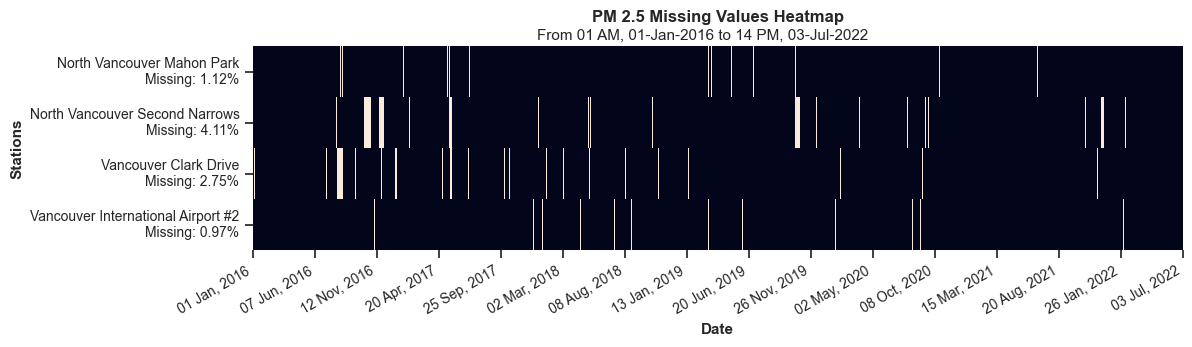

In [20]:
plot_missing(master_df.pivot(columns="STATION", values="PM 2.5"))

### Evaluation subsets
List of months with no missing value across all four stations

In [21]:
# Looking for months without missing values
months_complete = {}
for station in stations:
    months_complete[station] = []
    station_subset = master_df[master_df["STATION"] == station]
    for year in range (2016, 2022):
        if year == 2022:
            range_max = 7 # Limiting upper range for 2022 as data goes up to July
        else:
            range_max = 13
        for month in range(1, range_max):
            if month == 12:
                subset = station_subset[datetime(year, month, 1, 1): datetime(year, month, 31, 23)]
            else:
                subset = station_subset[datetime(year, month, 1, 1): datetime(year, month+1, 1)]
            if subset['PM 2.5'].isna().sum() == 0:
                months_complete[station].append((month, year))

for station in months_complete:
    print(f"{station} has {len(months_complete[station])} complete months:\n{months_complete[station]}\n")

Vancouver_Clark_Drive_PM25 has 3 complete months:
[(4, 2016), (10, 2016), (2, 2019)]

Vancouver_International_Airport_#2_PM25 has 3 complete months:
[(4, 2016), (7, 2016), (4, 2019)]

North_Vancouver_Mahon_Park_PM25 has 5 complete months:
[(1, 2016), (4, 2016), (6, 2016), (6, 2017), (2, 2018)]

North_Vancouver_Second_Narrows_PM25 has 9 complete months:
[(2, 2016), (6, 2016), (7, 2016), (3, 2017), (4, 2017), (9, 2017), (2, 2019), (4, 2019), (6, 2019)]



In [22]:
# Experimental subsets
exp_subsets = {}

for station in months_complete:
    exp_subsets[station] = {}
    for months in months_complete[station]: # Iterating on list of tuples (month, year) | (4, 2016)
        month = months[0]
        year = months[1]
        if month == 12:
            next_month = 1
            next_year = year+1
        else:
            next_month = month+1
            next_year = year
        exp_subsets[station][f'{month}-{year}'] = master_df[master_df['STATION'] == station][
            datetime(year, month, 1):datetime(next_year, next_month, 1)
        ]

In [23]:
for station in exp_subsets:
    print(f'{station}:\n {exp_subsets[station].keys()}\n')

Vancouver_Clark_Drive_PM25:
 dict_keys(['4-2016', '10-2016', '2-2019'])

Vancouver_International_Airport_#2_PM25:
 dict_keys(['4-2016', '7-2016', '4-2019'])

North_Vancouver_Mahon_Park_PM25:
 dict_keys(['1-2016', '4-2016', '6-2016', '6-2017', '2-2018'])

North_Vancouver_Second_Narrows_PM25:
 dict_keys(['2-2016', '6-2016', '7-2016', '3-2017', '4-2017', '9-2017', '2-2019', '4-2019', '6-2019'])



In [24]:
exp_subsets['North_Vancouver_Mahon_Park_PM25']['1-2016'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2016-01-01 01:00:00 to 2016-02-01 00:00:00
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   STATION     744 non-null    object 
 1   PM 2.5      744 non-null    float64
 2   isMissing   744 non-null    int64  
 3   seqMissing  744 non-null    int64  
 4   isCMV       744 non-null    int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 34.9+ KB


### Experimentation method
Backwards missing value generation.

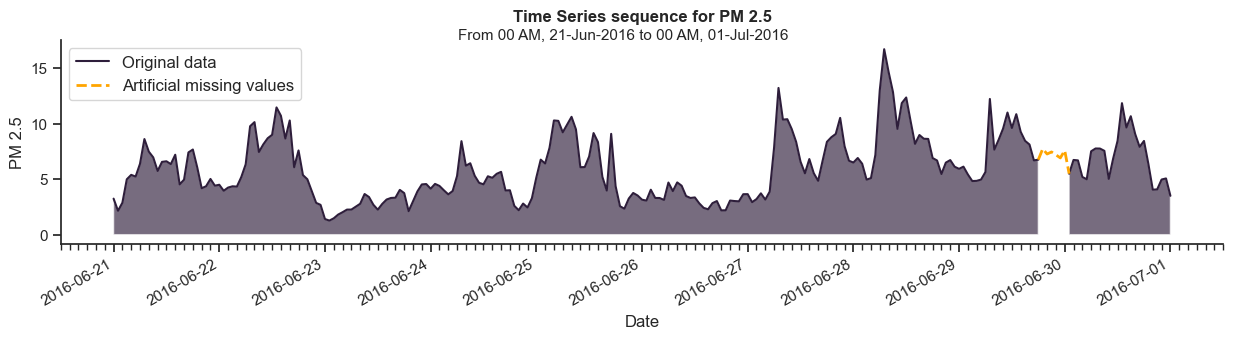

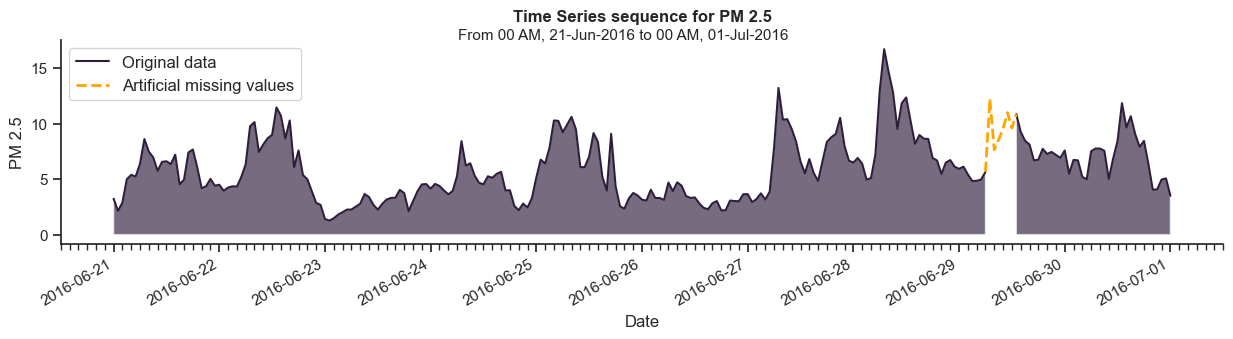

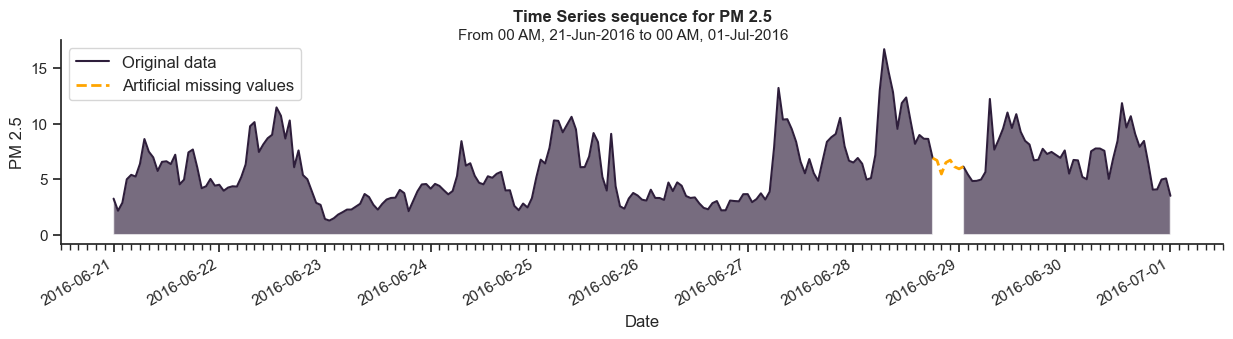

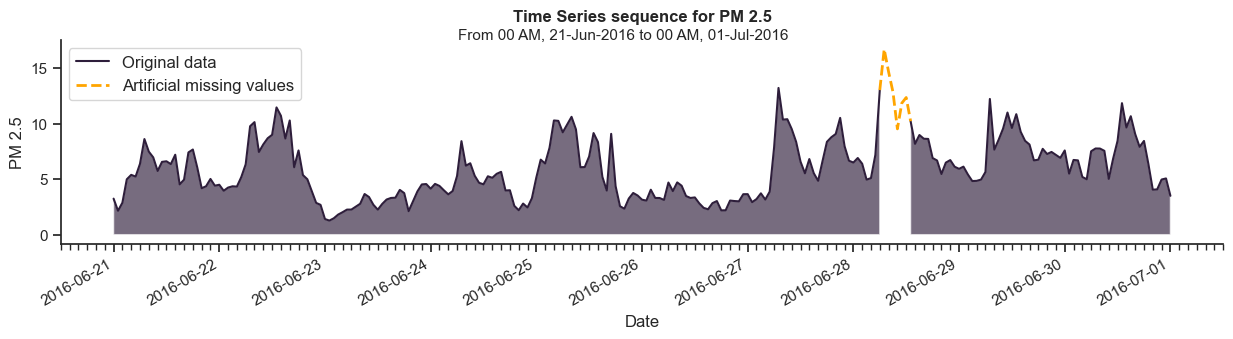

In [25]:
# Implementation example iterating through different paddings
paddings = [24, 36, 48, 60]

for padding in paddings:
    subset, subset_missing = create_missing(
        data=station_subset,
        value="PM 2.5",
        start=datetime(2016, 6, 21),
        end=datetime(2016, 7, 1),
        missing_length=6,
        padding=padding,
        missing_index="end",
    )
    plot_compare(
        subset,
        subset_missing,
        value="PM 2.5",
        value_missing="PM 2.5",
        missing_only=True,
        data_label="Artificial missing values",
        data_missing_label="Original data",
        figsize=(15, 3)
    )

Imputation example with linear interpolation

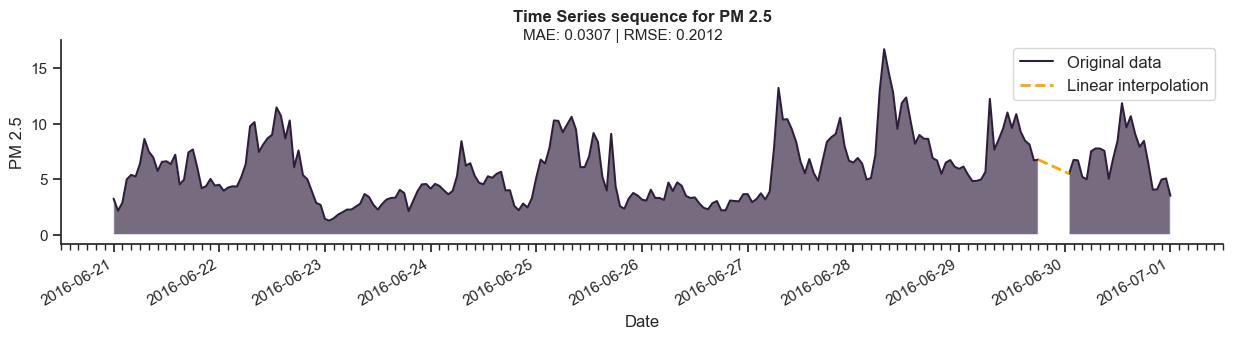

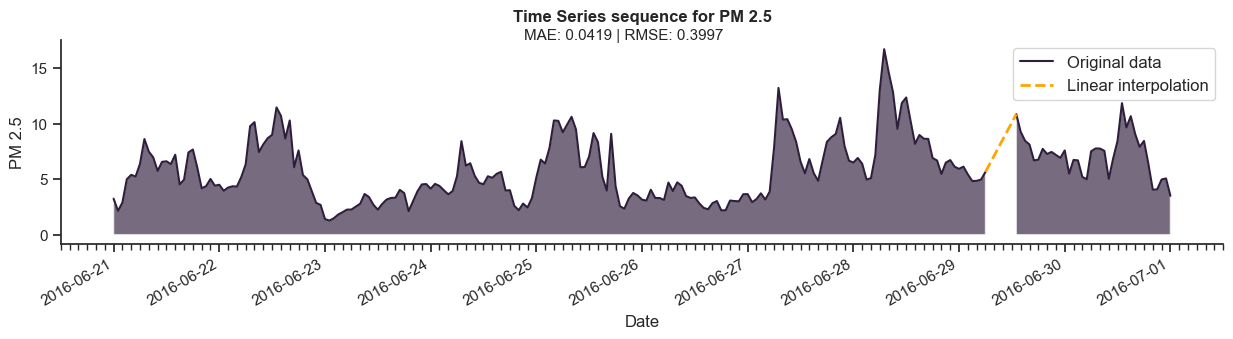

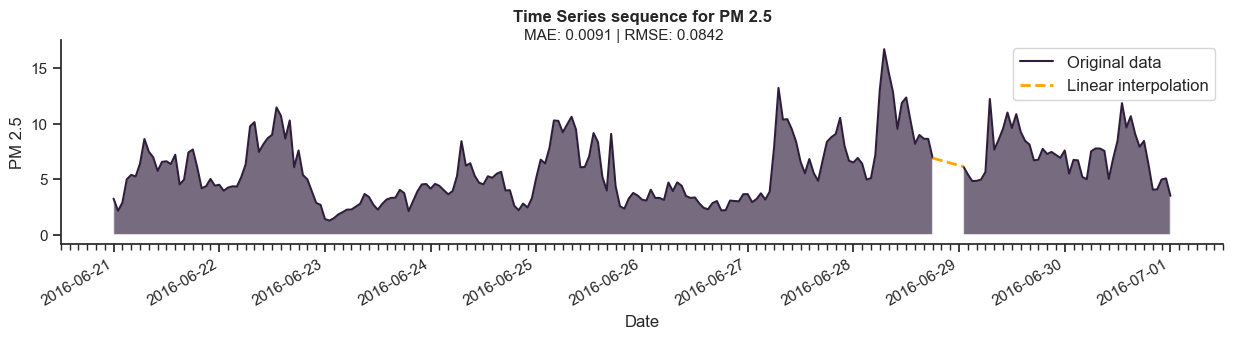

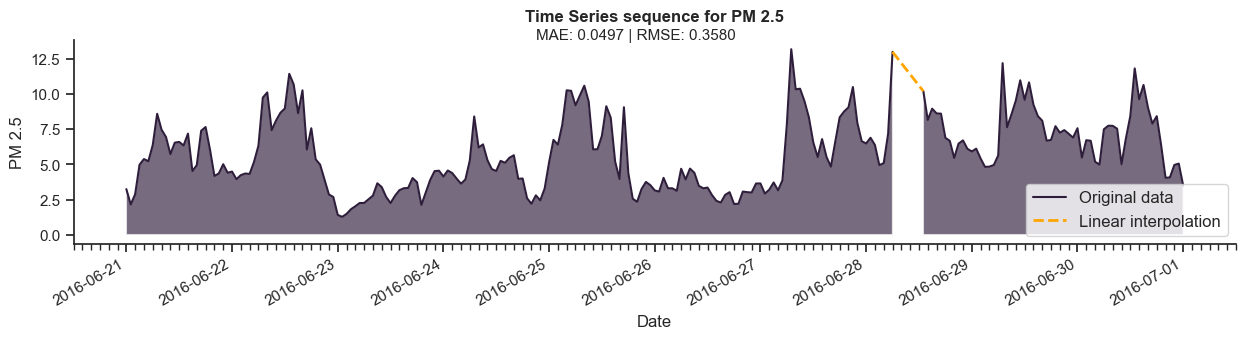

In [26]:
# Implementation example with linear interpolation:
for padding in paddings:
    subset, subset_missing = create_missing(
        data=station_subset,
        value="PM 2.5",
        start=datetime(2016, 6, 21),
        end=datetime(2016, 7, 1),
        missing_length=6,
        padding=padding,
        missing_index="end",
    )

    subset_linear = subset.copy()
    subset_linear["PM 2.5"] = (
        subset_missing["PM 2.5"].interpolate(method="linear").tolist()
    )
    
    plot_compare(
        subset_linear,
        subset_missing,
        value="PM 2.5",
        value_missing="PM 2.5",
        missing_only=True,
        data_label="Linear interpolation",
        data_missing_label="Original data",
        plot_sup_title=f"MAE: {mae_score(subset, subset_linear, value='PM 2.5', verbose=False):.4f}\
 | RMSE: {rmse_score(subset, subset_linear, value='PM 2.5', verbose=False):.4f}",
        figsize=(15, 3)
    )

Imputation example with cubic spline

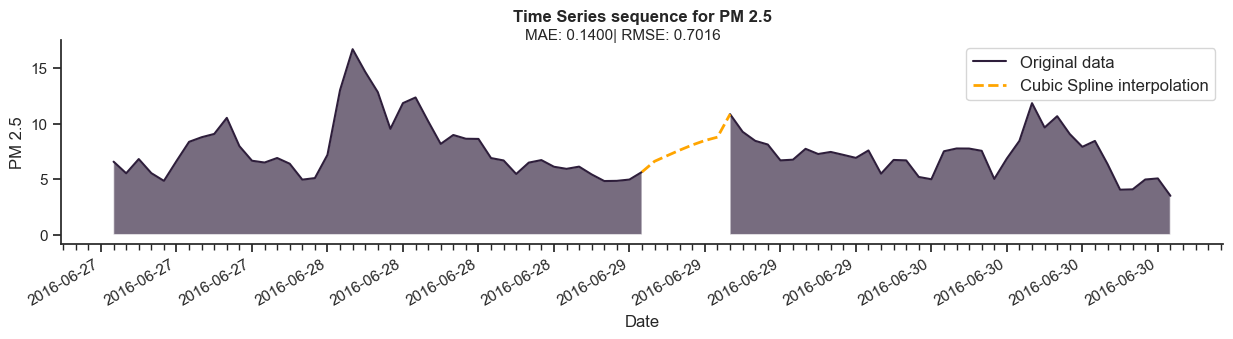

In [35]:
# Cubic spline interpolation - Pandas Series.interpolate
subset, subset_missing = create_missing(
    data=station_subset,
    value='PM 2.5',
    start=datetime(2016, 6, 27, 12),
    end=datetime(2016, 7, 1),
    missing_length=6,
    padding=36, #24, 36, 48, 60
    missing_index='end',
)

subset_spline = subset.copy()
subset_spline["PM 2.5"] = (
    subset_missing["PM 2.5"].interpolate(method="spline", order=3).tolist()
)

plot_compare(
    subset_spline,
    subset_missing,
    value="PM 2.5",
    value_missing="PM 2.5",
    missing_only=True,
    data_label="Cubic Spline interpolation",
    data_missing_label="Original data",
    plot_sup_title=f"MAE: {mae_score(subset, subset_spline, value='PM 2.5', verbose=False):.4f}\
| RMSE: {rmse_score(subset, subset_spline, value='PM 2.5', verbose=False):.4f}",
    figsize=(15, 3)
)

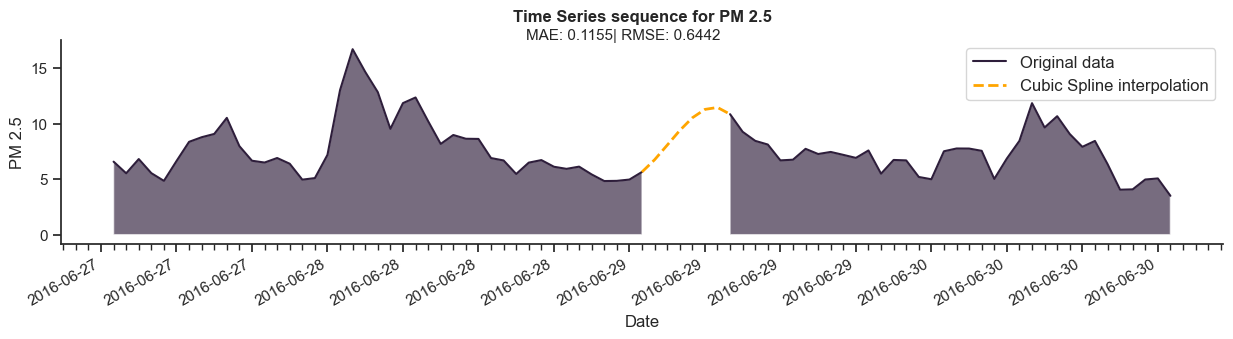

In [36]:
# Cubic spline interpolation - Scipy interpolate.splrep
pd.options.mode.chained_assignment = None # Shutdown warnings when working on slices of dataframes
from scipy import interpolate

subset, subset_missing = create_missing(
    data=station_subset,
    value='PM 2.5',
    start=datetime(2016, 6, 27, 12),
    end=datetime(2016, 7, 1),
    missing_length=6,
    padding=36, #24, 36, 48, 60
    missing_index='end',
)

subset_spline = subset.copy()
# Indexing missing values
missing_idx = np.where(subset_missing["PM 2.5"].isna())[0].tolist()

# Indexing boundary values at t-2, t-1, t+1, and t+2
boundary_idx = []
for idx in range(min(missing_idx)-2, max(missing_idx)+3):
    if idx not in missing_idx:
        boundary_idx.append(idx)
boundary = subset_missing["PM 2.5"][boundary_idx].tolist()

# Fitting cubic spline
cubic_spline = interpolate.splrep(x=boundary_idx, y=boundary, k=3)
imputed = interpolate.splev(missing_idx, cubic_spline)

subset_spline["PM 2.5"][missing_idx] = imputed

plot_compare(
    subset_spline,
    subset_missing,
    value="PM 2.5",
    value_missing="PM 2.5",
    missing_only=True,
    data_label="Cubic Spline interpolation",
    data_missing_label="Original data",
    plot_sup_title=f"MAE: {mae_score(subset, subset_spline, value='PM 2.5', verbose=False):.4f}\
| RMSE: {rmse_score(subset, subset_spline, value='PM 2.5', verbose=False):.4f}",
    figsize=(15, 3)
)

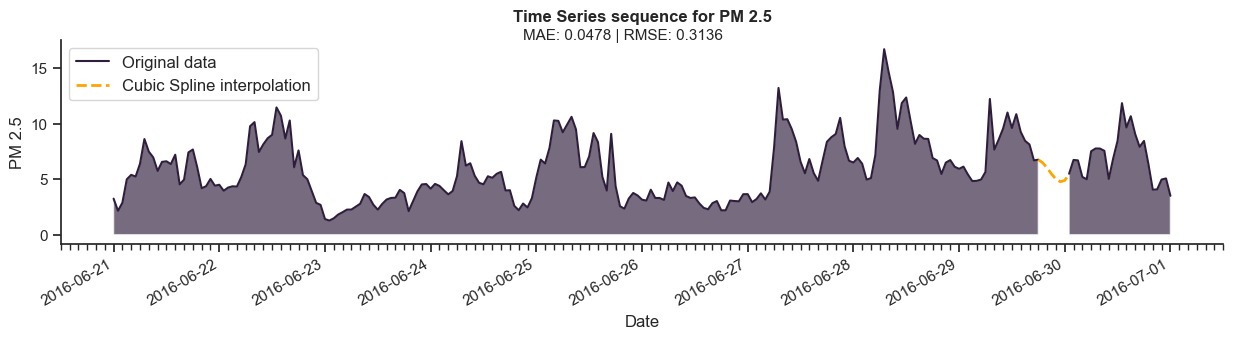

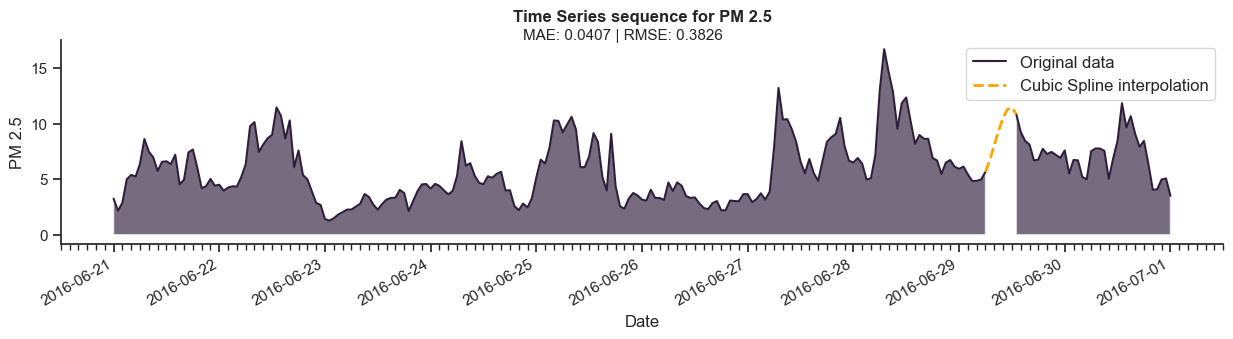

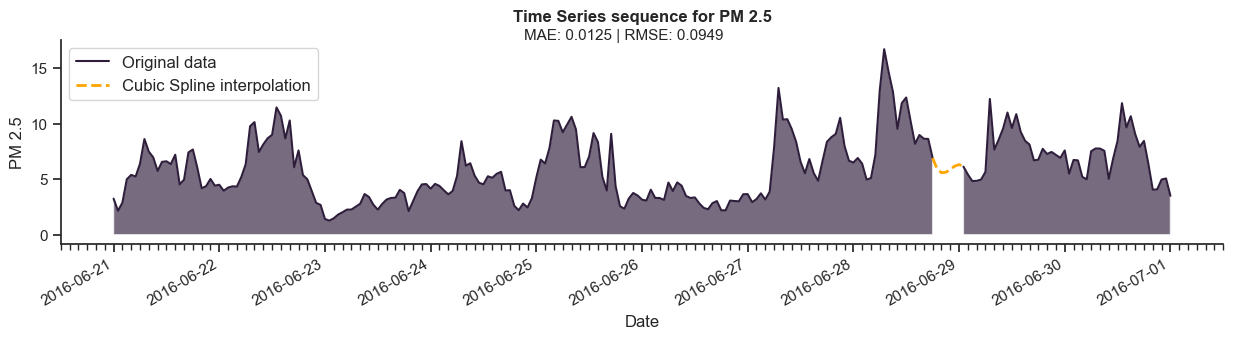

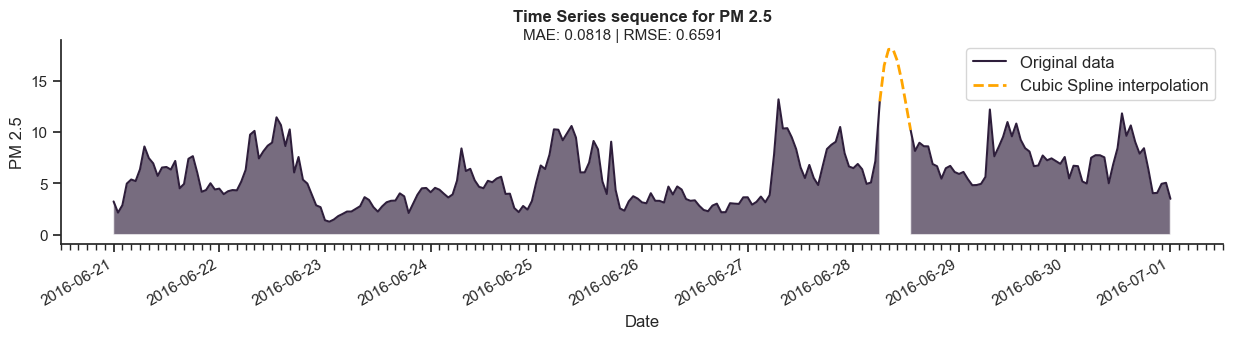

In [37]:
# Implementation example with cubic spline interpolation
for padding in paddings:
    subset, subset_missing = create_missing(
        data=station_subset,
        value="PM 2.5",
        start=datetime(2016, 6, 21),
        end=datetime(2016, 7, 1),
        missing_length=6,
        padding=padding,
        missing_index="end",
    )

    subset_spline = subset.copy()
    # Indexing missing values
    missing_idx = np.where(subset_missing["PM 2.5"].isna())[0].tolist()

    # Indexing boundary values at t-2, t-1, t+1, and t+2
    boundary_idx = []
    for idx in range(min(missing_idx)-2, max(missing_idx)+3):
        if idx not in missing_idx:
            boundary_idx.append(idx)
    boundary = subset_missing["PM 2.5"][boundary_idx].tolist()

    # Fitting cubic spline
    cubic_spline = interpolate.splrep(x=boundary_idx, y=boundary, k=3)
    imputed = interpolate.splev(missing_idx, cubic_spline)

    subset_spline["PM 2.5"][missing_idx] = imputed

    plot_compare(
        subset_spline,
        subset_missing,
        value="PM 2.5",
        value_missing="PM 2.5",
        missing_only=True,
        data_label="Cubic Spline interpolation",
        data_missing_label="Original data",
        plot_sup_title=f"MAE: {mae_score(subset, subset_spline, value='PM 2.5', verbose=False):.4f}\
 | RMSE: {rmse_score(subset, subset_spline, value='PM 2.5', verbose=False):.4f}",
        figsize=(15, 3)
    )

>Ref.: _Carl de Boor, “A Practical Guide to Splines”, Springer-Verlag, 1978. pp 40-50_

### Linear and Cubic Spline imputation of Short Sequences
* Iteration through missing lengths ∈ (1h, 2h)
* For each subset, generate missing lengths on every hour, from right to left
* Measure Root-Mean-Square Error (RMSE) and Mean-Absolute Error (MAE) against original data

In [40]:
%%time
# Iterate through stations, then subsets to evaluate linear interpolation vs. cubic spline
from tqdm import tqdm

# Artificial missing values function parameters
create_missing_args = {
    "value": "PM 2.5",
    "missing_index": "end"
}

imputation_results = {}
for station in (pbar := tqdm(exp_subsets)):
    pbar.set_description(f"Processing station {station}")
    for station_subset in exp_subsets[station]:
        imputation_step = str(station + "_" + station_subset)
        imputation_results[imputation_step] = {}
        imputation_results[imputation_step]["RMSE_Cubic"] = []
        imputation_results[imputation_step]["RMSE_Linear"] = []
        imputation_results[imputation_step]["MAE_Cubic"] = []
        imputation_results[imputation_step]["MAE_Linear"] = []
        imputation_results[imputation_step]["Missing_Length"] = []        
        # Generating backwards missing intervals
        paddings = [i for i in range(2, len(exp_subsets[station][station_subset]))]
        for padding in paddings:
            # Creating missing interval with length = 1 and length = 2
            for length in [1, 2]:
                subset, subset_missing = create_missing(
                    **create_missing_args,
                    data=exp_subsets[station][station_subset],
                    padding=padding,
                    missing_length=length
                )
                ### Cubic spline
                subset_spline = subset.copy()
                missing_idx = np.where(subset_missing["PM 2.5"].isna())[0].tolist()

                # Indexing boundary values at t-2, t-1, t+1, and t+2
                boundary_idx = []
                for idx in range(min(missing_idx)-2, max(missing_idx)+3):
                    if idx not in missing_idx:
                        boundary_idx.append(idx)
                boundary = subset_missing["PM 2.5"][boundary_idx].tolist()

                # Fitting cubic spline
                cubic_spline = interpolate.splrep(x=boundary_idx, y=boundary, k=3)
                imputed = interpolate.splev(missing_idx, cubic_spline)
                subset_spline["PM 2.5"][missing_idx] = imputed

                # Evaluating cubic spline
                rmse_cubic = rmse_score(subset, subset_spline, value="PM 2.5", verbose=False)
                mae_cubic = mae_score(subset, subset_spline, value="PM 2.5", verbose=False)
                imputation_results[imputation_step]["RMSE_Cubic"].append(rmse_cubic)
                imputation_results[imputation_step]["MAE_Cubic"].append(mae_cubic)

                ### Linear interpolation
                subset_linear = subset.copy()
                subset_linear["PM 2.5"] = subset_missing["PM 2.5"].interpolate(method="linear", inplace=False).tolist()

                # Evaluating linear interpolation
                rmse_linear = rmse_score(subset, subset_linear, value="PM 2.5", verbose=False)
                mae_linear = mae_score(subset, subset_linear, value="PM 2.5", verbose=False)
                imputation_results[imputation_step]["RMSE_Linear"].append(rmse_linear)
                imputation_results[imputation_step]["MAE_Linear"].append(mae_linear)
                imputation_results[imputation_step]["Missing_Length"].append(length)

Processing station North_Vancouver_Second_Narrows_PM25: 100%|██████████| 4/4 [01:09<00:00, 17.42s/it]    

CPU times: user 1min 9s, sys: 40 ms, total: 1min 9s
Wall time: 1min 9s


In [41]:
# Concatenating master dataframe
subsets = []
for subset in imputation_results.keys():
    subsets.append(pd.DataFrame(imputation_results[subset]))

metrics_df = pd.concat(subsets).reset_index(drop=True)
metrics_df.round(6).head()

,RMSE_Cubic,RMSE_Linear,MAE_Cubic,MAE_Linear,Missing_Length
0,0.033493,0.024058,0.001247,0.000896,1
1,0.050441,0.051899,0.001883,0.002001,2
2,0.050351,0.050928,0.001875,0.001897,1
3,0.059907,0.051147,0.002644,0.001921,2
4,0.026684,0.025138,0.000994,0.000936,1


### RMSE and MAE results

In [43]:
metrics_df.groupby("Missing_Length").describe(percentiles=[]).T.round(5)

Missing_Length               1            2
RMSE_Cubic  count  14331.00000  14331.00000
            mean       0.03324      0.06474
            std        0.04989      0.08141
            min        0.00001      0.00024
            50%        0.01754      0.03899
            max        0.80107      1.29857
RMSE_Linear count  14331.00000  14331.00000
            mean       0.03193      0.05956
            std        0.04772      0.07408
            min        0.00000      0.00000
            50%        0.01698      0.03662
            max        0.78733      1.38782
MAE_Cubic   count  14331.00000  14331.00000
            mean       0.00124      0.00314
            std        0.00187      0.00399
            min        0.00000      0.00001
            50%        0.00065      0.00186
            max        0.03088      0.06828
MAE_Linear  count  14331.00000  14331.00000
            mean       0.00119      0.00288
            std        0.00178      0.00359
            min        0.00000      0.00000
            50%        0.00063      0.00176
            max        0.03002      0.07297

In [44]:
# Melting dataframes for boxplot visualizations
RMSE_melt_df = pd.melt(metrics_df[["RMSE_Cubic", "RMSE_Linear", "Missing_Length"]].rename(columns=lambda x: x.split("_")[1]),
                      id_vars="Length",
                      var_name="Method",
                      value_name="RMSE")

MAE_melt_df = pd.melt(metrics_df[["MAE_Cubic", "MAE_Linear", "Missing_Length"]].rename(columns=lambda x: x.split("_")[1]),
                      id_vars="Length",
                      var_name="Method",
                      value_name="MAE")

display(RMSE_melt_df.head())
print(RMSE_melt_df.shape)
display(MAE_melt_df.head())
print(MAE_melt_df.shape)

,Length,Method,RMSE
0,1,Cubic,0.033493
1,2,Cubic,0.050441
2,1,Cubic,0.050351
3,2,Cubic,0.059907
4,1,Cubic,0.026684


(57324, 3)


,Length,Method,MAE
0,1,Cubic,0.001247
1,2,Cubic,0.001883
2,1,Cubic,0.001875
3,2,Cubic,0.002644
4,1,Cubic,0.000994


(57324, 3)


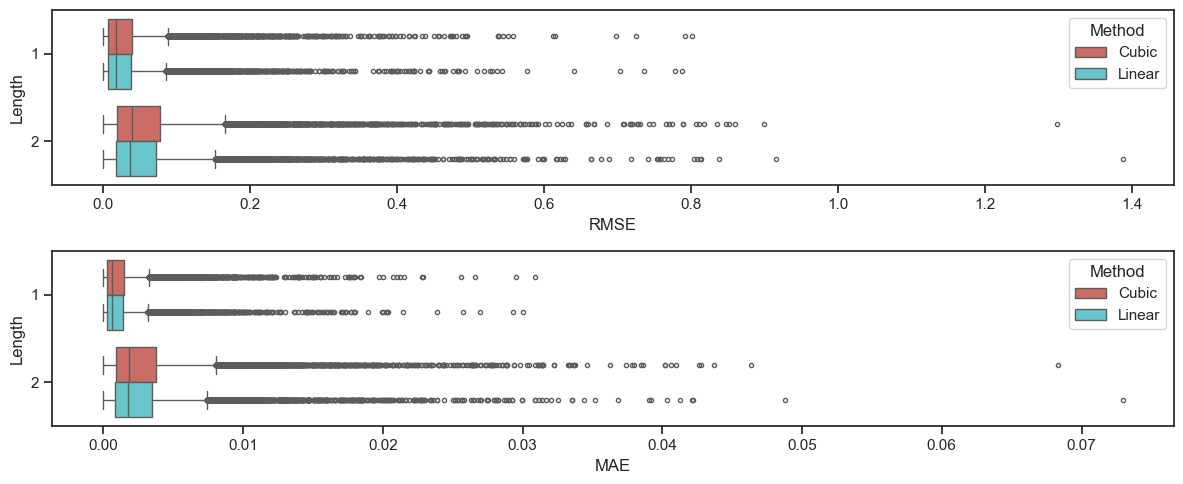

In [48]:
# Boxplot of metrics results
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
box_plot_args = {
    "y": "Length",
    "hue": "Method",
    "palette": "hls",
    "orient": "h",
    "flierprops": {'marker': '.'}
}
sns.boxplot(RMSE_melt_df,
            x="RMSE",
            ax=axs[0],
            **box_plot_args)
sns.boxplot(MAE_melt_df,
            x="MAE",
            ax=axs[1],
            **box_plot_args)
fig.tight_layout()
plt.show()

RMSE metrics without outliers: (56139, 3). Outliers removed: 1185.
MAE metrics without outliers: (56148, 3). Outliers removed: 1176.


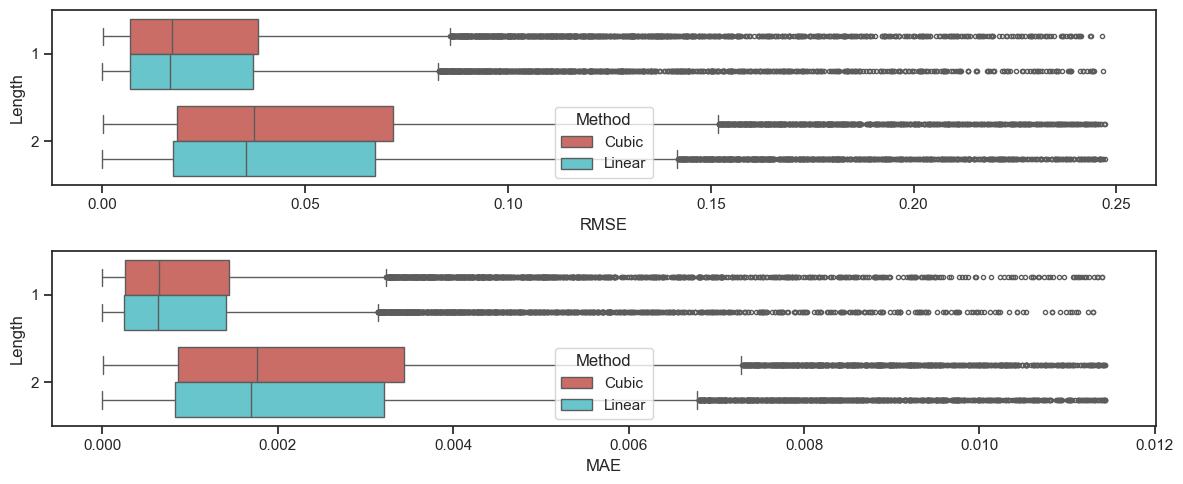

In [49]:
# Metrics without outliers
RMSE_melt_df_noout = RMSE_melt_df[(np.abs(stats.zscore(RMSE_melt_df["RMSE"])) < 3)]
MAE_melt_df_noout = MAE_melt_df[(np.abs(stats.zscore(MAE_melt_df["MAE"])) < 3)]
print(f"RMSE metrics without outliers: {RMSE_melt_df_noout.shape}.\
 Outliers removed: {MAE_melt_df.shape[0] - RMSE_melt_df_noout.shape[0]}.")
print(f"MAE metrics without outliers: {MAE_melt_df_noout.shape}.\
 Outliers removed: {MAE_melt_df.shape[0] - MAE_melt_df_noout.shape[0]}.")

# Boxplot of metrics results without outliers
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
sns.boxplot(RMSE_melt_df_noout,
            x="RMSE",
            ax=axs[0],
            **box_plot_args)
sns.boxplot(MAE_melt_df_noout,
            x="MAE",
            ax=axs[1],
            **box_plot_args)
fig.tight_layout()
plt.show()

### Imputing short sequences [1h, 2h]
* Imputation of short sequences up to 2h with linear method

,Missing,Missing %
STATION,0,0.00
PM 2.5,4958,2.22
isMissing,0,0.00
seqMissing,0,0.00
isCMV,0,0.00


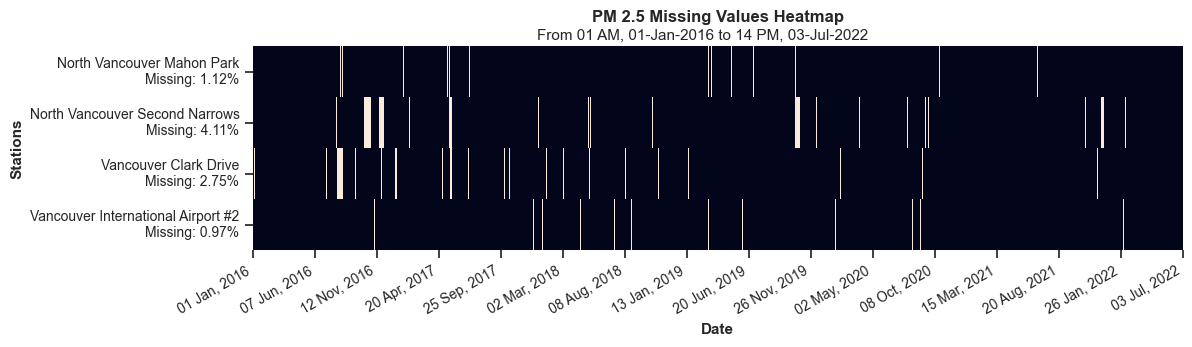

In [50]:
# Missing summary before linear interpolation imputation
missing_tot = master_df.isna().sum()
missing_pct = round(master_df.isna().sum()/master_df.count()*100, 2)
missing_summary = pd.concat([missing_tot, missing_pct], axis=1)
missing_summary.rename(columns={0: 'Missing', 1: 'Missing %'}, inplace=True)
display(missing_summary)

plot_missing(master_df.pivot(columns="STATION", values="PM 2.5"))

,Missing,Missing %
STATION,0,0.00
PM 2.5,4175,1.86
isMissing,0,0.00
seqMissing,0,0.00
isCMV,0,0.00


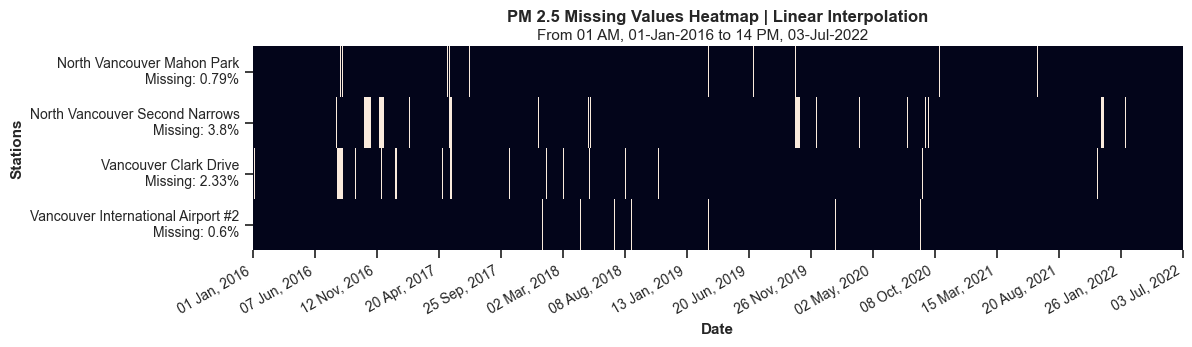

In [52]:
# Linear interpolation imputation
master_df.loc[master_df["seqMissing"] <= 2, "PM 2.5"] = master_df.loc[master_df["seqMissing"] <= 2, "PM 2.5"].interpolate()

# Missing summary
missing_tot = master_df.isna().sum()
missing_pct = round(master_df.isna().sum()/master_df.count()*100, 2)
missing_summary = pd.concat([missing_tot, missing_pct], axis=1)
missing_summary.rename(columns={0: 'Missing', 1: 'Missing %'}, inplace=True)
display(missing_summary)

plot_missing(master_df.pivot(columns="STATION", values="PM 2.5"), plot_title="PM 2.5 Missing Values Heatmap | Linear Interpolation")

## Imputation of long sequences (>= 2h)
- MICE univariate
- MICE multivariate